# **Individual Coding Project Code**

- Student name: Aswin Subramanian Maheswaran

##  **Project Title**: 


### **Objectives:**
- 

### **Data sources:**

- 

#### **I. Setup the environment:**

In [13]:
# Install necessary packages
%pip install geopandas shapely pyproj tqdm plotly mapboxgl osmnx

Note: you may need to restart the kernel to use updated packages.


In [14]:
# Import libraries

import random
import os
import zipfile
import pandas as pd
import numpy as np
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point, LineString
from shapely.ops import split
from shapely import affinity
from pyproj import CRS
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Modelling

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_recall_curve,
    roc_curve,
    confusion_matrix,
    classification_report,
)
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold


# Random seed

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
ox.settings.log_console = False
ox.settings.use_cache   = True


In [15]:
# ---- spatial params ----

CRS_LONLAT  = "EPSG:4326"
CRS_METRIC  = "EPSG:3857"     # meters (for Spain)
COUNTRY_CODE = "ES"
FOCUS_BUF_M  = 1000           # 1 km focus window around GBIF points
MATCH_MAX_M  = 200            # max distance GBIF -> segment to count as a match
SEG_TARGET_M = 500            # ~500 m segment length
INTERSECT_NEAR_M = 250        # radius to count nearby endpoints

# ---- OSM fetch params ----
OSM_TILE_DIST_M = 7000        # download 7 km circles around tile centroids
ROUND_DEG = 0.1               # 11 km lat/lon rounding for GBIF tiling



## **Part 1: Building the dataset - GeoDataFrame**

###    1.1 Clean the GBIF dataset. 

In [16]:
GBIF_FILEPATH = "data.csv"

GBIF_COLUMNS = [
    "gbifID","occurrenceID","countryCode",
    "decimalLatitude","decimalLongitude",
    "eventDate","year","month","day",
    "scientificName","basisOfRecord","coordinateUncertaintyInMeters"
]

road_kill = pd.read_csv(GBIF_FILEPATH, low_memory=False, sep='\t', on_bad_lines='skip')
road_kill = road_kill[[cols for cols in GBIF_COLUMNS if cols in road_kill.columns]].copy()


# a. basic parsing and filters

convert_to_numeric = lambda s: pd.to_numeric(s, errors="coerce")
road_kill["decimalLatitude"] = convert_to_numeric(road_kill["decimalLatitude"])
road_kill["decimalLongitude"] = convert_to_numeric(road_kill["decimalLongitude"])
road_kill["year"] = convert_to_numeric(road_kill["year"])
road_kill["month"] = convert_to_numeric(road_kill["month"])
road_kill["day"] = convert_to_numeric(road_kill["day"])

# b. Parse eventDate

road_kill["eventDate"] = pd.to_datetime(road_kill["eventDate"], errors="coerce")
fallback_date = pd.to_datetime(road_kill[["year", "month", "day"]], errors="coerce")
# fill the missing eventDate with fallback_date
road_kill["eventDate"] = road_kill["eventDate"].fillna(fallback_date)

# c. Filter by country code

filter_records = (
    
    (road_kill['countryCode'] == COUNTRY_CODE) &
    road_kill['decimalLatitude'].between(-90, 90) & road_kill['decimalLongitude'].between(-180, 180)
)

road_kill = road_kill[filter_records].dropna(subset=['decimalLatitude','decimalLongitude']).copy()

# d. Convert to GeoDataFrame and set CRS

road_kill_gdf = gpd.GeoDataFrame(
    road_kill, 
    geometry=gpd.points_from_xy(road_kill["decimalLongitude"], road_kill["decimalLatitude"]), 
    crs=CRS_LONLAT
).to_crs(CRS_METRIC)


print(f"GBIF's Spain records after cleaning: {len(road_kill_gdf)}")
print()
road_kill_gdf.head(2)

GBIF's Spain records after cleaning: 5050



,gbifID,occurrenceID,countryCode,decimalLatitude,decimalLongitude,eventDate,year,month,day,scientificName,basisOfRecord,coordinateUncertaintyInMeters,geometry
18,5100845320,060e8d29-0ad6-401d-a85f-97a0081d950c,ES,37.065452,-6.647498,2006-09-20,2006,9.0,20.0,"Pelobates cultripes (Cuvier, 1829)",HUMAN_OBSERVATION,30.0,POINT (-739996.092 4448233.883)
51,5100845353,985a81fc-6083-4429-bbbd-8bfcd09028e2,ES,37.356580,-6.341840,2011-04-09,2011,4.0,9.0,"Emberiza calandra Linnaeus, 1758",HUMAN_OBSERVATION,30.0,POINT (-705970.399 4488926.675)


###    1.2 Sample of GBIF Roadkill points in Spain

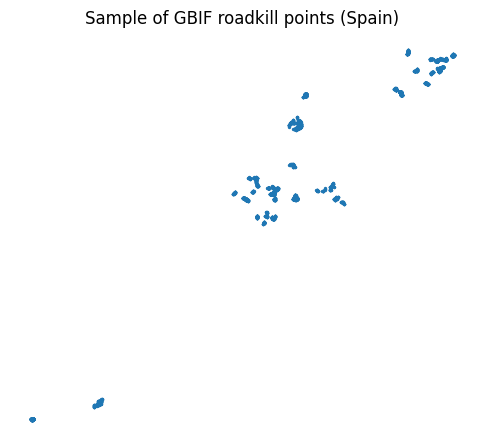

In [17]:
ax = road_kill_gdf.sample(min(5000, len(road_kill_gdf)), random_state=RANDOM_SEED).plot(
    markersize=2, figsize=(6,6)
)
ax.set_title("Sample of GBIF roadkill points (Spain)")
ax.axis("off")
plt.show()

####    **Insights into the data**

- **Challenge:** GBIF data is presence-only as it shows where animals were found dead, not where they weren't. This creates inherent bias.

    -   The absence data is missing, we don't know where animals were not found, only where they were. 
    -   Sampling bias, as observations are focused in locations with more activity (human activity and road infrastructure). 
    -   This bias must be taken into account when training the predictive model, as the absence of observations do not necessarily demonstrate low risk. 

###    1.3 Focus-window and Area of Interest (AOI) 